In [48]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc
import parfit.parfit as pf
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


In this task, as an illustration of a real-world problem, you are asked to predict the evolution of hospital patients' states and needs during their stay in the Intensive Care Unit (ICU). For each patient, you are provided with the monitoring information collected during the first 12h of their stay. From the data, you first need to extract meaningful features describing this 12h stay. Then, for each sub-task, you should select an appropriate model to train on your pre-processed data. You will face the typical challenges of working with real medical data: missing features and imbalanced classification, predicting rarely-occuring events.

In [49]:
# load data set
df_train_features = pd.read_csv('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')
df_test_features = pd.read_csv('test_features.csv')

# pre-process the training data (impute the missing data)
training_features = pd.DataFrame(df_train_features.groupby(['pid']).mean())
imputed_training_features = training_features.reset_index().drop(columns=['pid', 'Time']).fillna(training_features.mean())

# pre-process the test data (impute the missing data)
test_features = pd.DataFrame(df_test_features.groupby(['pid']).mean())
imputed_test_features = test_features.reset_index().drop(columns=['pid', 'Time']).fillna(test_features.mean())

# format the training labels
training_labels = df_train_labels.drop(columns=['pid'])

**Sub-Task 1**

Here we are interested in anticipating the future needs of the patient. You have to predict whether a certain medical test is ordered by a clinician in the remaining stay. This sub-task is a binary classification : 0 means that there will be no further tests of this kind ordered whereas 1 means that at least one is ordered in the remaining stay.

The corresponding columns containing the binary ground truth in train_labels.csv are: LABEL_BaseExcess, LABEL_Fibrinogen, LABEL_AST, LABEL_Alkalinephos, LABEL_Bilirubin_total, LABEL_Lactate, LABEL_TroponinI, LABEL_SaO2, LABEL_Bilirubin_direct, LABEL_EtCO2.

Because there is an imbalance between labels in these sub-tasks we evaluate the performance of a model with the Area Under the Receiver Operating Characteristic Curve, which is a threshold-based metric. To achieve good performance, it is important to produce (probabilistic) real-valued predictions in the interval [0, 1].

0.4989780859889762
0.49636471570137175
0.48936750272628127
0.49375645883568714
0.49379913458657737
0.4985655388785958
0.510680912742113
0.49875528336394215
0.5
0.5


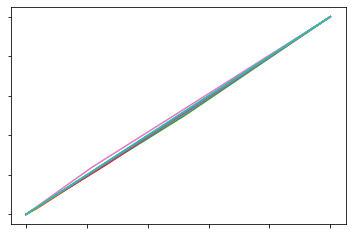

In [50]:

# labels needed for sub-task 1
labels_1 = training_labels[['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2']]

# split training data into training and validation set
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(imputed_training_features, labels_1, test_size= 0.2, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', max_iter=1000, tol=1e-3))

for col in labels_1:
    clf.fit(X_train_1, y_train_1[col])
    y_pred_1 = clf.predict(X_val_1)
    fpr, tpr, thresholds = metrics.roc_curve(y_val_1[col], y_pred_1)
    plt.plot(fpr, tpr)
    print(roc_auc_score(y_val_1[col], y_pred_1))
    


# avg_ROC = 

0.4970167068590521
0.4985746864310148
0.5003717656389411
0.5005580357142857
0.5151496649462056
0.4995018266356692
0.5
0.5
0.49959116925592806
0.4979502403166525


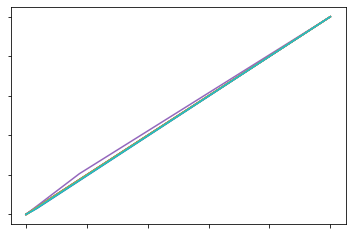

In [51]:
# labels needed for sub-task 1
labels_1 = training_labels[['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2']]

# split training data into training and validation set
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(imputed_training_features, labels_1, test_size= 0.2, random_state=42)

# clf = make_pipeline(StandardScaler(), SGDClassifier(loss='squared_epsilon_insensitive', penalty='elasticnet', fit_intercept=False, max_iter=1000, tol=1e-3, shuffle=False))
# clf = RandomForestClassifier()
clf = SGDClassifier(max_iter=1000, tol=1e-3)

for col in labels_1:
    clf.fit(X_train_1, y_train_1[col])
    y_pred_1 = clf.predict(X_val_1)
    fpr, tpr, thresholds = metrics.roc_curve(y_val_1[col], y_pred_1)
    plt.plot(fpr, tpr)
    print(roc_auc_score(y_val_1[col], y_pred_1))

**Sub-Task 2**

In this sub-task, we are interested in anticipating future life-threatening events. You have to predict whether a patient is likely to have a sepsis event in the remaining stay. This task is also a binary classification : 0 means that no sepsis will occur, 1 otherwise.

The corresponding column containing the binary ground-truth in train_labels.csv is LABEL_Sepsis.

This task is also imbalanced, thus we’ll also evaluate performance using Area Under the Receiver Operating Characteristic Curve.

In [52]:
# labels needed for sub-task 2
labels_2 = training_labels[['LABEL_Sepsis']]

**Sub-Task 3**

In this type of sub-task, we are interested in predicting a more general evolution of the patient state. To this effect, here we aim at predicting the mean value of a vital sign in the remaining stay. This is a regression task.

The corresponding columns containing the real-valued ground truth in train_labels.csv are: LABEL_RRate, LABEL_ABPm, LABEL_SpO2, LABEL_Heartrate.

To evaluate the performance of a given model on this sub-task we use R2 Score.

In [53]:
# labels needed for sub-task 3
labels_3 = training_labels[['LABEL_RRate', 'LABEL_ABPm', 'LABEL_SpO2', 'LABEL_Heartrate']]

**Submission**

In [54]:
X_test_st1 = imputed_test_features

# suppose df is a pandas dataframe containing the result
#df.to_csv('prediction.zip', index=False, float_format='%.3f', compression='zip')